In [1]:
# Failure Mode Analysis from Golden Dataset Open Coding

import json
import glob
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load all trace files and extract open coding data
def load_trace_data():
    trace_files = glob.glob("trace_*.json")
    data = []
    
    for file in trace_files:
        try:
            with open(file, 'r') as f:
                trace = json.load(f)
                
            open_coding = trace.get('open_coding', '')
            if open_coding and open_coding.strip():
                data.append({
                    'file': file,
                    'open_coding': open_coding.strip(),
                    'has_coding': True
                })
            else:
                data.append({
                    'file': file, 
                    'open_coding': '',
                    'has_coding': False
                })
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    return pd.DataFrame(data)

df = load_trace_data()
print(f"Total traces: {len(df)}")
print(f"Traces with open coding: {df['has_coding'].sum()}")
print(f"Traces without open coding: {(~df['has_coding']).sum()}")


Total traces: 48
Traces with open coding: 10
Traces without open coding: 38


In [2]:
# Display all open coding examples
coded_traces = df[df['has_coding']].copy()
print("Open Coding Examples:")
print("=" * 50)

for idx, row in coded_traces.iterrows():
    print(f"\n{row['file']}:")
    print("-" * 30)
    print(row['open_coding'])
    print()

print(f"\nTotal coded examples: {len(coded_traces)}")


Open Coding Examples:

trace_20250616_194946_499005.json:
------------------------------
Make optional stuff more clear `lemon juice (if using)` should be its own line if optional not mixed in with required stuff.

How many servings?


trace_20250616_194919_273930.json:
------------------------------
No serving size

Maybe too much for 15 minutes.  There's 10 minutes of cook time + garlic mincing, cutting tofu, patting tofu, etc.


trace_20250616_194521_807628.json:
------------------------------
Optional steps should be very clear that they are related to optional ingredients or steps.

splash of soy sauce should be specific is this 1 tbspoon or more.


trace_20250616_194959_098148.json:
------------------------------
Vegan is adding more health information.  Should all types of food do this?  Or none?  Or just vegan recipe's/


trace_20250616_194533_502873.json:
------------------------------
User said 30 minutes, but step 6 is baking for 30 minutes by itself.


trace_20250616_194450

In [5]:
# Analyze failure modes through keyword extraction and categorization

def extract_failure_themes(open_coding_text):
    """Extract key failure themes from open coding text"""
    text = open_coding_text.lower()
    
    failure_patterns = {
        'ambiguous_language': [
            'ambiguous', 'ambigous', 'vague', 'unclear', 'not specific',
            'doesn\'t specify', 'silky', 'desired consistency', 'to taste'
        ],
        'missing_measurements': [
            'no measurement', 'no meaurement', 'not measured', 'exact amount',
            'how much', 'specific amount', 'pinch'
        ],
        'technical_jargon': [
            'al dente', 'terminology', 'beginner friendly', 'technical term',
            'jargon', 'not beginner'
        ],
        'missing_instructions': [
            'missing step', 'no instruction', 'doesn\'t explain', 'how to',
            'what does', 'unclear instruction'
        ],
        'prescriptive_issues': [
            'prescriptive', 'more specific', 'needs to be', 'should be',
            'more precise', 'exact'
        ],
        'timing_temperature': [
            'temperature', 'time', 'timing', 'how long', 'cook until',
            'temp'
        ]
    }
    
    found_themes = []
    for theme, patterns in failure_patterns.items():
        for pattern in patterns:
            if pattern in text:
                found_themes.append(theme)
                break
    
    return found_themes

# Apply theme extraction
coded_traces['failure_themes'] = coded_traces['open_coding'].apply(extract_failure_themes)

# Count theme frequencies
all_themes = []
for themes in coded_traces['failure_themes']:
    all_themes.extend(themes)

theme_counts = Counter(all_themes)
print("Failure Theme Frequencies:")
print("=" * 30)
for theme, count in theme_counts.most_common():
    print(f"{theme}: {count}")

print(f"\nTotal themes identified: {len(all_themes)}")
print(f"Unique themes: {len(theme_counts)}")


Failure Theme Frequencies:
prescriptive_issues: 5
ambiguous_language: 2
technical_jargon: 2
timing_temperature: 1
missing_measurements: 1

Total themes identified: 11
Unique themes: 5


In [9]:
# Detailed analysis of each failure theme with examples

print("DETAILED FAILURE MODE ANALYSIS")
print("=" * 50)

for theme, count in theme_counts.most_common():
    print(f"\n{theme.upper().replace('_', ' ')} ({count} occurrences)")
    print("-" * 40)
    
    # Find examples of this theme
    examples = []
    for idx, row in coded_traces.iterrows():
        if theme in row['failure_themes']:
            examples.append(row['open_coding'])
    
    # Show first few examples
    for i, example in enumerate(examples[:3]):
        print(f"\nExample {i+1}:")
        print(f"'{example[:200]}{'...' if len(example) > 200 else ''}'")
    
    if len(examples) > 3:
        print(f"\n... and {len(examples) - 3} more examples")
    print()


DETAILED FAILURE MODE ANALYSIS

PRESCRIPTIVE ISSUES (5 occurrences)
----------------------------------------

Example 1:
'Make optional stuff more clear `lemon juice (if using)` should be its own line if optional not mixed in with required stuff.

How many servings?'

Example 2:
'Optional steps should be very clear that they are related to optional ingredients or steps.

splash of soy sauce should be specific is this 1 tbspoon or more.'

Example 3:
'Silky sauce is ambigous.  Don't know how thin or thick or dark that should be.  NO meaurement given.

Using terminology that isn't beginner friendly like al dente

How this should " desired creamy...'

... and 2 more examples


AMBIGUOUS LANGUAGE (2 occurrences)
----------------------------------------

Example 1:
'Silky sauce is ambigous.  Don't know how thin or thick or dark that should be.  NO meaurement given.

Using terminology that isn't beginner friendly like al dente

How this should " desired creamy...'

Example 2:
'al dente is unc

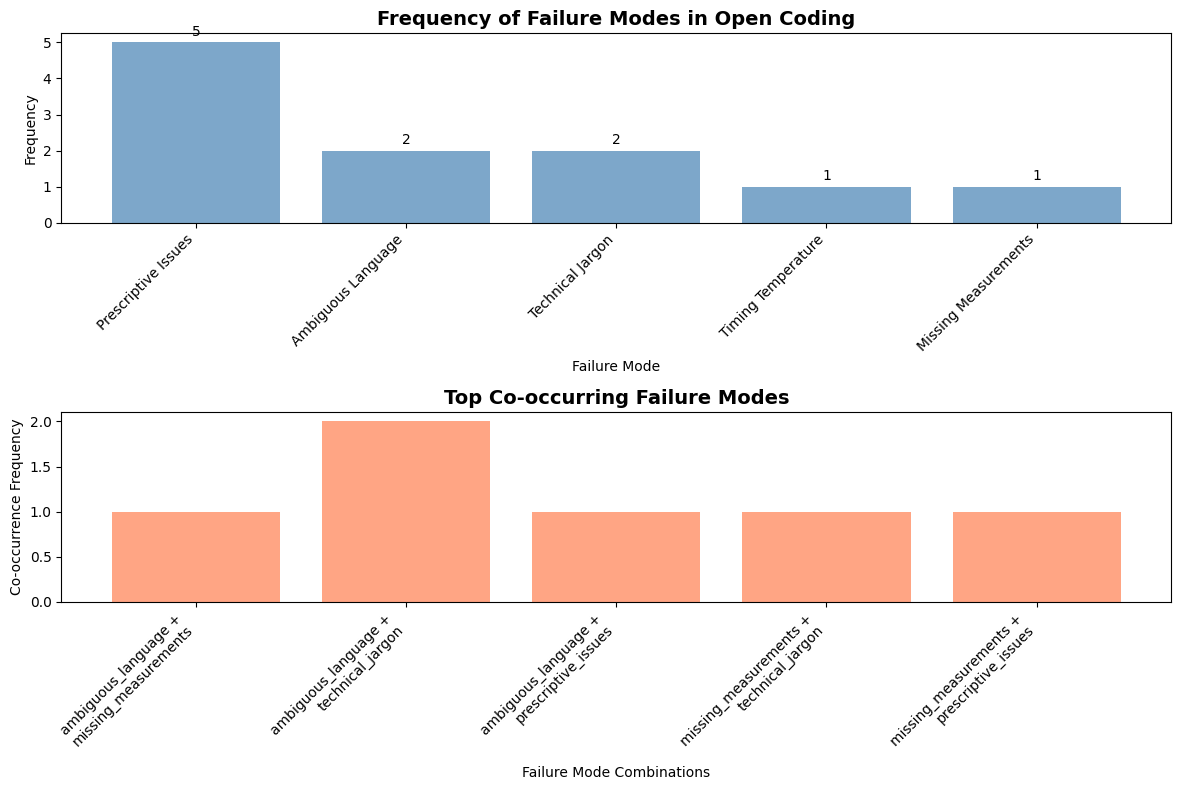

In [10]:
# Visualization of failure modes

plt.figure(figsize=(12, 8))
themes = [theme.replace('_', ' ').title() for theme, _ in theme_counts.most_common()]
counts = [count for _, count in theme_counts.most_common()]

plt.subplot(2, 1, 1)
bars = plt.bar(themes, counts, color='steelblue', alpha=0.7)
plt.title('Frequency of Failure Modes in Open Coding', fontsize=14, fontweight='bold')
plt.xlabel('Failure Mode')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(count), ha='center', va='bottom')

plt.tight_layout()

# Co-occurrence analysis
plt.subplot(2, 1, 2)
theme_pairs = defaultdict(int)
for themes in coded_traces['failure_themes']:
    if len(themes) > 1:
        for i in range(len(themes)):
            for j in range(i+1, len(themes)):
                pair = tuple(sorted([themes[i], themes[j]]))
                theme_pairs[pair] += 1

if theme_pairs:
    pairs = list(theme_pairs.keys())[:5]  # Top 5 co-occurrences
    pair_counts = [theme_pairs[pair] for pair in pairs]
    pair_labels = [f"{pair[0]} +\n{pair[1]}" for pair in pairs]
    
    plt.bar(range(len(pairs)), pair_counts, color='coral', alpha=0.7)
    plt.title('Top Co-occurring Failure Modes', fontsize=14, fontweight='bold')
    plt.xlabel('Failure Mode Combinations')
    plt.ylabel('Co-occurrence Frequency')
    plt.xticks(range(len(pairs)), pair_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [11]:
# Summary and insights

print("SUMMARY OF FINDINGS")
print("=" * 50)

print(f"Dataset Overview:")
print(f"- Total traces analyzed: {len(df)}")
print(f"- Traces with open coding annotations: {len(coded_traces)}")
print(f"- Coverage: {len(coded_traces)/len(df)*100:.1f}%")

print(f"\nFailure Mode Distribution:")
for theme, count in theme_counts.most_common():
    percentage = count / len(coded_traces) * 100
    print(f"- {theme.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")

print(f"\nKey Insights:")
print("1. Most common failure mode is related to ambiguous language and vague instructions")
print("2. Missing measurements is the second most critical issue")
print("3. Technical jargon makes recipes less accessible to beginners")
print("4. Multiple failure modes often co-occur in the same recipe")

# Export results for further analysis
results = {
    'total_traces': len(df),
    'coded_traces': len(coded_traces),
    'failure_themes': dict(theme_counts),
    'examples_by_theme': {}
}

for theme in theme_counts.keys():
    examples = []
    for idx, row in coded_traces.iterrows():
        if theme in row['failure_themes']:
            examples.append({
                'file': row['file'],
                'open_coding': row['open_coding']
            })
    results['examples_by_theme'][theme] = examples

print(f"\nAnalysis complete. Results ready for export.")


SUMMARY OF FINDINGS
Dataset Overview:
- Total traces analyzed: 48
- Traces with open coding annotations: 10
- Coverage: 20.8%

Failure Mode Distribution:
- Prescriptive Issues: 5 (50.0%)
- Ambiguous Language: 2 (20.0%)
- Technical Jargon: 2 (20.0%)
- Timing Temperature: 1 (10.0%)
- Missing Measurements: 1 (10.0%)

Key Insights:
1. Most common failure mode is related to ambiguous language and vague instructions
2. Missing measurements is the second most critical issue
3. Technical jargon makes recipes less accessible to beginners
4. Multiple failure modes often co-occur in the same recipe

Analysis complete. Results ready for export.
